In [113]:
import importlib
import basic_functions as bf
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
# Now, reload the module
importlib.reload(bf)

<module 'basic_functions' from 'c:\\Users\\wusch\\OneDrive\\Desktop\\project_walouigi\\basic_functions.py'>

In [116]:
# Check if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device to see if you're using the GPU or CPU
print(f'Running on {device}')

Running on cuda


In [117]:
# Get the list of functions
function_list = [func for func in dir(bf) if callable(getattr(bf, func))]

# Print the list of functions
print(function_list)

['Adam', 'CrossEntropyLoss', 'StepLR', 'create_markov_chain', 'create_markov_chain_list_epsilon', 'create_transformer', 'generate_sequence', 'letter_to_number', 'number_to_letter', 'sequence_probability', 'train_model']


In [118]:
transition_matrices=bf.create_markov_chain_list_epsilon(0.1)
markov_chain_list=[bf.create_markov_chain(matrix) for matrix in transition_matrices]



In [127]:
initial_state = 0
context_window = 20
N = 1000  # number of times to sample each Markov chain
input_sequences = []
target_sequences = []
for generate_sequence in markov_chain_list:
    for _ in range(N):
        sequence = generate_sequence(initial_state, context_window+1)
        input_sequences.append(torch.tensor(sequence[1:]).long().to(device))
        target_sequences.append(torch.tensor(sequence[:-1]).long().to(device))
        #print("-------------------")
        #print(bf.number_to_letter(sequence))
        #print(bf.number_to_letter(sequence[1:]))
        #print(bf.number_to_letter(sequence[:-1]))



In [128]:


class MarkovChainDataset(Dataset):
    def __init__(self, input_sequences, target_sequences):
        assert len(input_sequences) == len(target_sequences)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Move each tensor in the lists to the device
        self.input_sequences = [seq.to(device) for seq in input_sequences]
        self.target_sequences = [seq.to(device) for seq in target_sequences]

    def __len__(self):
        return len(self.input_sequences)

    def __getitem__(self, index):
        return self.input_sequences[index], self.target_sequences[index]


In [129]:
dataset = MarkovChainDataset(input_sequences, target_sequences)
train_size = int(0.8 * len(dataset)) # 80% of the data for training
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 3. Create data loaders for batch processing

batch_size = 20  # Adjust this as needed

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)


model = bf.create_transformer(num_layers=4, vocab_size=3).to("cuda")


In [130]:
model_device = next(model.parameters()).device
print(f"Model is on device: {model_device}")

# Fetch one batch from train_loader
data_iter = iter(train_loader)
inputs, targets = next(data_iter)

# Check device for loader data
print(f"Inputs are on device: {inputs.device}")
print(f"Targets are on device: {targets.device}")

Model is on device: cuda:0
Inputs are on device: cuda:0
Targets are on device: cuda:0


In [131]:


# Assuming that your training function takes care of sending the data to the same device as the model, train the model
model.train()
model, loss_df=bf.train_model(model, train_loader, test_loader, num_epochs=40)
model.eval() 
# Save the loss dataframe to a csv file for later analysis
loss_df.to_csv('losses.csv', index=False)

Epoch: 0, Train Loss: 1.038422968685627, Test Loss: 0.8984960079193115
Epoch: 10, Train Loss: 0.6893419507145881, Test Loss: 0.6938914275169372
Epoch: 20, Train Loss: 0.6882192385196686, Test Loss: 0.6902226281166076
Epoch: 30, Train Loss: 0.6857165244221687, Test Loss: 0.6893123316764832


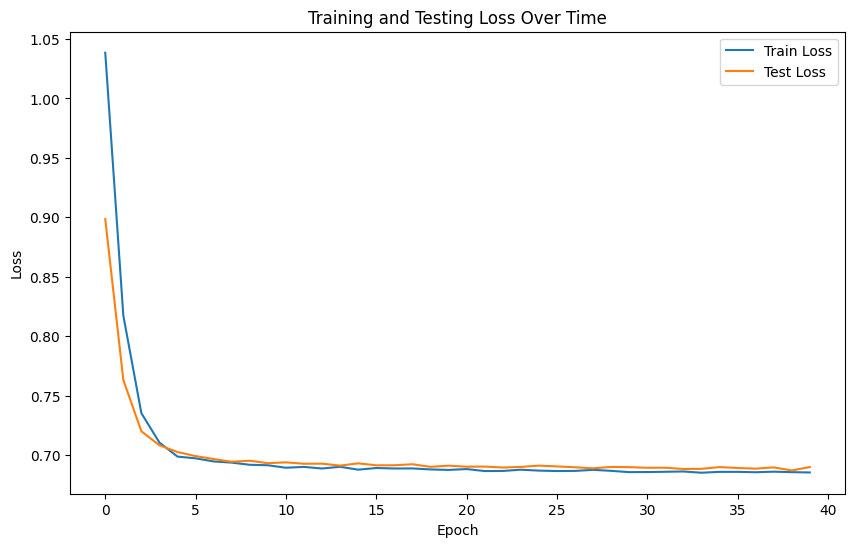

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(loss_df['epoch'], loss_df['train_loss'], label='Train Loss')
plt.plot(loss_df['epoch'], loss_df['test_loss'], label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Time')
#plt.yscale("log")
plt.legend()

plt.show()


In [136]:
prompt = 'BBBBBBBBBB'
prompt_numbers = bf.letter_to_number(prompt)
generated_numbers =  bf.generate_sequence(model, prompt_numbers, sequence_length=100)
generated_sequence =  bf.number_to_letter(generated_numbers)
print(generated_sequence)



BBBBBBBBBBAABAABABABABABAABAABABBABABAABABABBBCAABABAABAAABBABBBAABAABAABAAABAAABBABBABABAAABAAABABA


In [115]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

44603

In [100]:
import math

In [108]:
num_layers=4
d_model = 16   # Scale linearly with num_layers
dim_feedforward = 32 * num_layers   # Scale linearly with num_layers
nhead = min(8, max(4, int(math.log2(num_layers))))  

In [107]:
nhead

4